#Assignment 2

- Train and Evaluate a Logistic Regression Classifier with CIFAR-10 dataset using PyTorch
- Draw learning curve and confusion matrix
- Try and compare different hyper-parameters (show me some nice plots :) )
- Plot gradient norm for some learnable parameters (e.g., last layer or so)
- Extra point:
    - Use some package (e.g., *hyperot* or *optuna*) to optimize two hyper-parameters (e.g, learning rate or batch size)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
''' Move tensors to cuda/chosen device , dataloader to move data to chosen device'''
def move_to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [move_to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dataloader, device):
    self.dataloader = dataloader
    self.device = device
      
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dataloader: 
      yield move_to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dataloader)

In [ ]:
torch.manual_seed(43)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transform)

validation_data_size = len(trainset) / 10 #10% of the training set
training_data_size = len(trainset) - validation_data_size

training_set, validation_set = torch.utils.data.dataset.random_split(trainset, [int(training_data_size), int(validation_data_size)])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
training_data_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=True)
testing_data_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

train_data, train_labels = next(iter(training_data_loader))
validation_data, validation_labels = next(iter(validation_data_loader))
test_data, test_labels = next(iter(testing_data_loader))

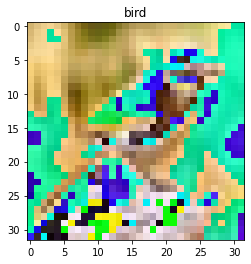

In [ ]:
i = 12
img = train_data[i]
_to_pil = transforms.ToPILImage()
plt.imshow(_to_pil(img))
plt.title(trainset.classes[train_labels[i]])
plt.show()

In [ ]:
device = get_default_device()
training_data_loader = DeviceDataLoader(training_data_loader, device)
validation_data_loader = DeviceDataLoader(validation_data_loader, device)
testing_data_loader = DeviceDataLoader(testing_data_loader, device)

In [ ]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
input_size = 3*32*32
output_size = len(classes)

class CIFAR10model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 64)
    self.linear4 = nn.Linear(64, 64)
    self.linear5 = nn.Linear(64, output_size)


  def Forward(self, input_image):
    output = input_image.view(input_image.size(0), -1)
    output = self.linear1(output)
    output = Functions.relu(output)
    output = self.linear2(output)
    output = Functions.relu(output)
    output = self.linear3(output)
    output = Functions.relu(output)
    output = self.linear4(output)
    output = Functions.relu(output)
    output = self.linear5(output)
    return output

In [ ]:
class Helpers(object):

    def accuracy(self, target_label, predicted_label):

        _, prediction = torch.max(predicted_label, dim=1)
        acc = torch.sum(prediction == target_label).item() / len(prediction)
        return torch.tensor(acc)

    def plot_curves(self, epochs, val_loss, val_acc, lr, epoch):

        fig, ax = plt.subplots(1, 2, figsize=(13,4))
        fig.suptitle(f"curves at learning rate: {lr} and epochs: {epoch}")
        # ax[0].set_title('Loss curve')
        # ax[1].set_title('Accuracy curve')
        ax[0].plot(epochs, val_loss, 'r', label='loss curve')
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("validation loss")
        ax[0].legend()
        ax[0].grid()
        ax[1].plot(epochs, val_acc, 'g', label='accuracy curve')
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("validation accuracy")
        ax[1].legend()
        ax[1].grid()
        plt.show()
        plt.close('fig')

    def confusion_matrix(self, model, test_data_loader):

        cm = np.zeros([10,10])
        with torch.no_grad():
            for images, labels in test_data_loader:
                predictions = model.Forward(images)
                maxPreds, preds = torch.max(predictions, dim=1)
                for idx, label in enumerate(labels):
                    cm[label.item(), preds[idx].item()] += 1 
        return cm

    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)

In [ ]:
class train_val(object):
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 metric,
                 validation_data_loader,
                 training_data_loader,
                 epoch=10):

        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.metric = metric
        self.val_data_loader = validation_data_loader
        self.train_data_loader = training_data_loader
        self.epoch = epoch

    def train(self, input_image, target_label, grad_flow=False):

        forward = self.model.Forward(input_image)
        loss = self.loss_function(forward, target_label)
        loss.backward()
        if grad_flow:
            Helpers().plot_grad_flow(self.model.named_parameters())
        self.optimizer.step()
        self.optimizer.zero_grad()
        result = self.metric(target_label, forward)

        return loss, result

    def validation(self, data_loader):

        loss = []
        result = []

        for image,label in data_loader:
            forward = self.model.Forward(image)
            loss.append(self.loss_function(forward, label))
            result.append(self.metric(label, forward))

        avg_loss = torch.stack(loss).mean()
        avg_result = torch.stack(result).mean()

        return avg_loss.item(), avg_result.item()

    def fit(self, grad_flow=False):
        epochs = []
        val_loss_list = []
        val_accu_list = []
        grad_dict = {}
        for i in range(self.epoch):
            for image, label in self.train_data_loader:
                loss, result = self.train(image, label, grad_flow)

            val_loss, val_accu = self.validation(self.val_data_loader)
            epochs.append(i)
            val_loss_list.append(val_loss)
            val_accu_list.append(val_accu)

        print(f"Epoch [{self.epoch}/{self.epoch}], Loss: {np.round(val_loss, 2)}, accuracy: {np.round(val_accu*100, 2)}")

        return epochs, val_loss_list, val_accu_list

*****************************************************************************************
Epoch [10/10], Loss: 1.94, accuracy: 46.15
Epoch:10, Learning rate:0.1, Validation loss:1.94, and Validation accuracy:46.15
Epoch:10, Learning rate:0.1, Testing loss:1.9, and Testing accuracy:47.37


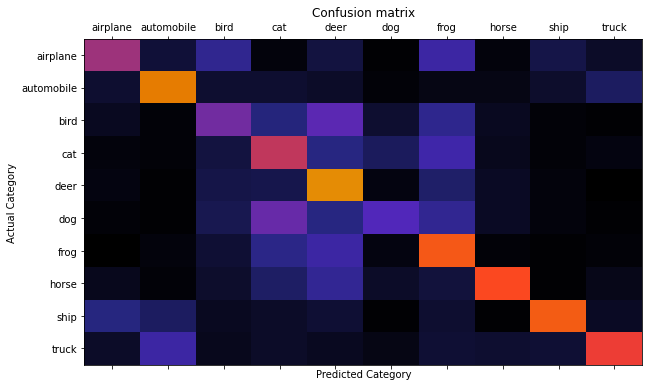

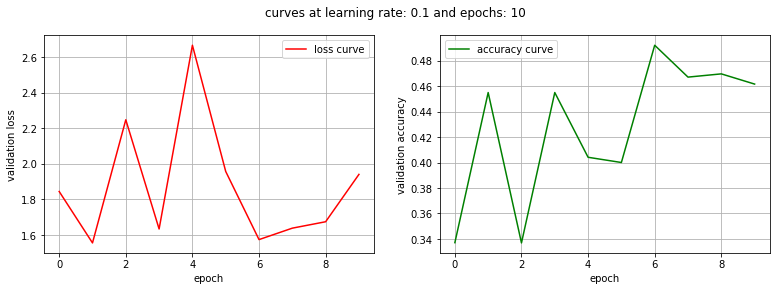

*****************************************************************************************
Epoch [10/10], Loss: 1.63, accuracy: 47.93
Epoch:10, Learning rate:0.3, Validation loss:1.63, and Validation accuracy:47.93
Epoch:10, Learning rate:0.3, Testing loss:1.58, and Testing accuracy:49.2


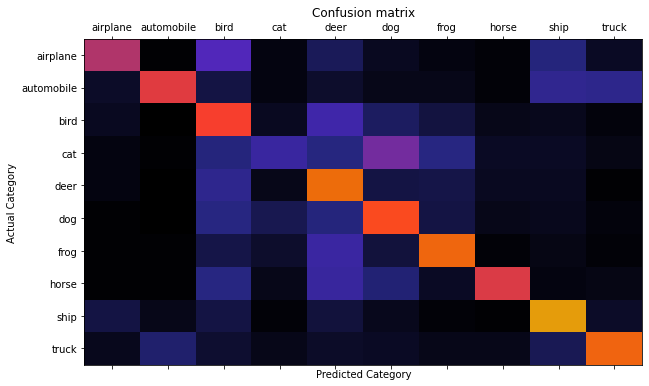

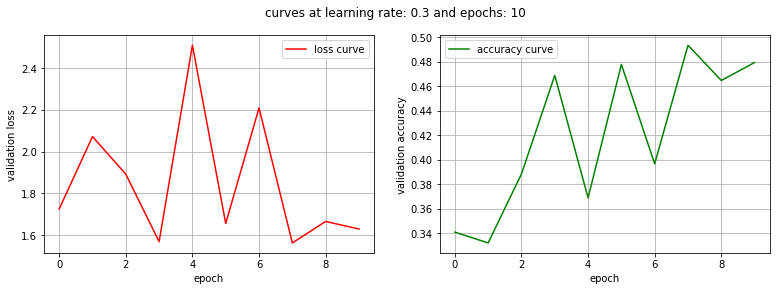

*****************************************************************************************
Epoch [20/20], Loss: 1.67, accuracy: 46.37
Epoch:20, Learning rate:0.01, Validation loss:1.67, and Validation accuracy:46.37
Epoch:20, Learning rate:0.01, Testing loss:1.61, and Testing accuracy:47.99


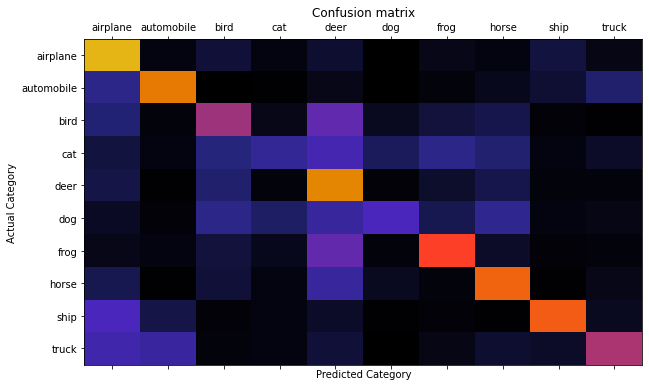

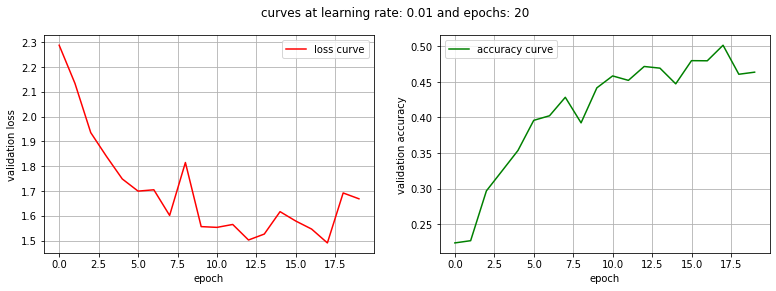

*****************************************************************************************
Epoch [20/20], Loss: 2.42, accuracy: 45.51
Epoch:20, Learning rate:0.03, Validation loss:2.42, and Validation accuracy:45.51
Epoch:20, Learning rate:0.03, Testing loss:2.4, and Testing accuracy:46.09


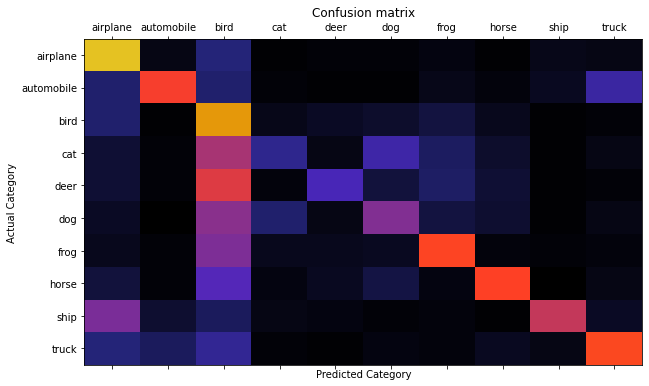

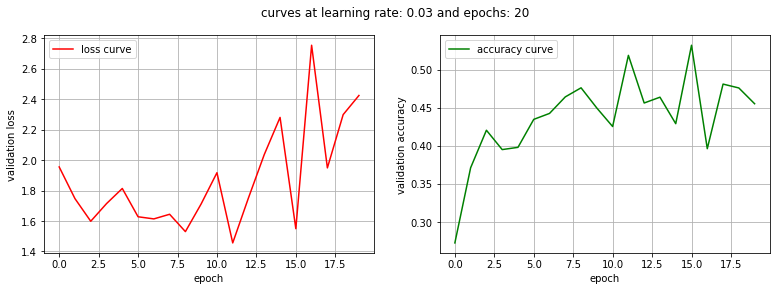

*****************************************************************************************
Epoch [15/15], Loss: 1.75, accuracy: 37.29
Epoch:15, Learning rate:0.003, Validation loss:1.75, and Validation accuracy:37.29
Epoch:15, Learning rate:0.003, Testing loss:1.73, and Testing accuracy:38.06


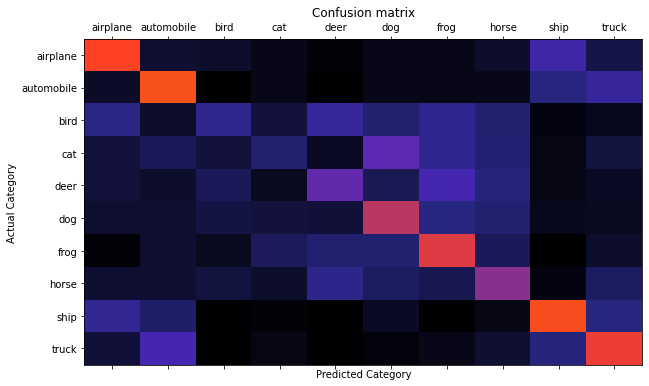

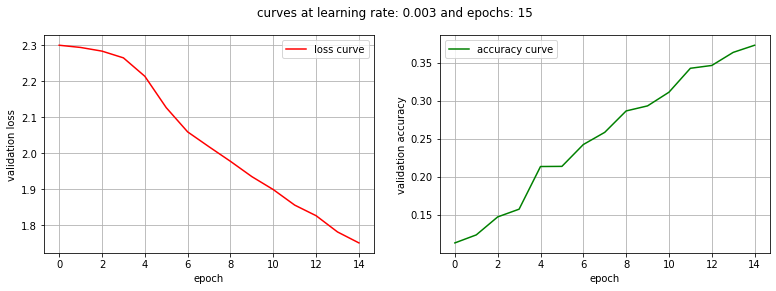

*****************************************************************************************
Epoch [50/50], Loss: 3.79, accuracy: 55.23
Epoch:50, Learning rate:0.03, Validation loss:3.79, and Validation accuracy:55.23
Epoch:50, Learning rate:0.03, Testing loss:3.64, and Testing accuracy:55.97


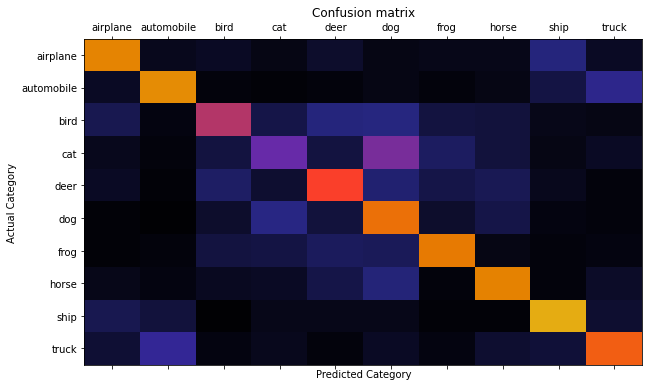

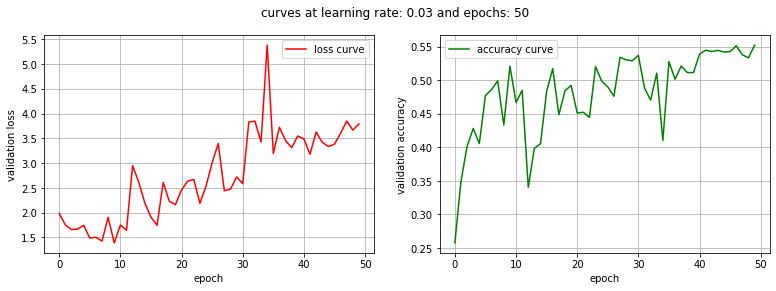

In [ ]:
epoch_learning_rate = [(10, 0.1), (10, 0.3), (20, 0.01), (20, 0.03), (15, 0.003), (50, 0.03)]
loss_function = Functions.cross_entropy
for epoch, lr in epoch_learning_rate:
  print('*****************************************************************************************')
  model = move_to_device(CIFAR10model(), device)
  optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.75)
  model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
  epochs, validation_loss, validation_accuracy = model_fit.fit()
  test_loss, test_accuracy = model_fit.validation(testing_data_loader)

  print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
  print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
  cm = Helpers().confusion_matrix(model, testing_data_loader)
  fig, ax = plt.subplots(1,1,figsize=(10,6))
  ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
  plt.title("Confusion matrix")
  plt.ylabel('Actual Category')
  plt.yticks(range(10), classes)
  plt.xlabel('Predicted Category')
  plt.xticks(range(10), classes)
  plt.show()
  Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)

Epoch [10/10], Loss: 1.63, accuracy: 47.99


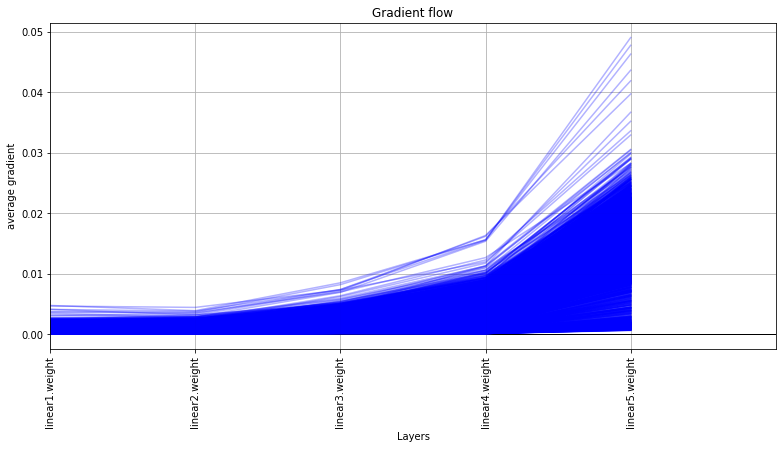

In [ ]:
#plotting gradient norm for each layer.
loss_function = Functions.cross_entropy
model = move_to_device(CIFAR10model(), device)
optimizer = torch.optim.ASGD(model.parameters(), lr=0.03)
model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=10)
plt.figure(figsize=(13,6))
epochs, validation_loss, validation_accuracy = model_fit.fit(grad_flow=True)
plt.show()
# epochs, validation_loss, validation_accuracy, grad_dict = test_fit(model, loss_function, optimizer, training_data_loader, validation_data_loader, accuracy, epoch=10, grad_flow=True)

# Extra: Hyperopt

In [ ]:
# using hyperopt

from hyperopt import hp

In [ ]:
space = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
         'alpha': hp.uniform('alpha', 0.0, 1.0),
         'epoch': hp.choice('epoch', np.arange(10, 100, 10, dtype=int))}

In [ ]:
loss_function = Functions.cross_entropy
model = move_to_device(CIFAR10model(), device)
optimizer = torch.optim.ASGD(model.parameters(), lr=0.03)
model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)

In [ ]:
from hyperopt import STATUS_OK
def objective(params):
    lr = params['learning_rate']
    alpha = params['alpha']
    epoch = params['epoch']
    model = move_to_device(CIFAR10model(), device)
    optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=alpha)
    model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
    # loss = test_fit1(model, loss_function, optimizer, training_data_loader, validation_data_loader, accuracy, epoch=10)
    epochs, validation_loss, validation_accuracy = model_fit.fit(grad_flow=False)
    loss = validation_loss[-1]
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import Trials

bayes_trials = Trials()
tpe_algorithm = tpe.suggest
MAX_EVALS = 5

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
print(best)

Epoch [50/50], Loss: 3.83, accuracy: 53.28
Epoch [90/90], Loss: 3.86, accuracy: 57.19
Epoch [70/70], Loss: 3.45, accuracy: 53.75
Epoch [20/20], Loss: 3.62, accuracy: 44.36
Epoch [30/30], Loss: 2.97, accuracy: 52.54
100%|██████████| 5/5 [34:51<00:00, 418.25s/it, best loss: 2.9713990688323975]
{'alpha': 0.6749601342772893, 'epoch': 2, 'learning_rate': 0.0538146337729848}


Epoch [30/30], Loss: 3.11, accuracy: 50.78
Epoch:30, Learning rate:0.053, Validation loss:3.11, and Validation accuracy:50.78
Epoch:30, Learning rate:0.053, Testing loss:2.98, and Testing accuracy:51.26


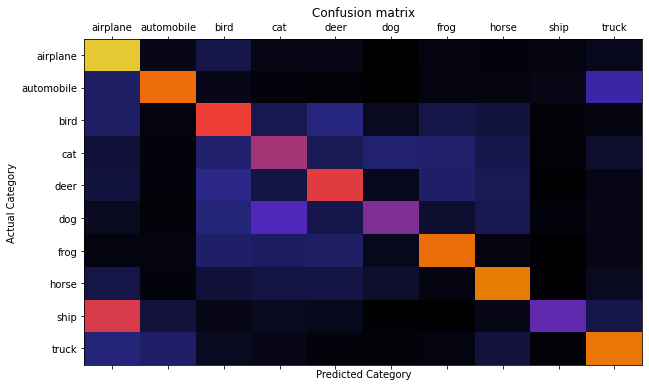

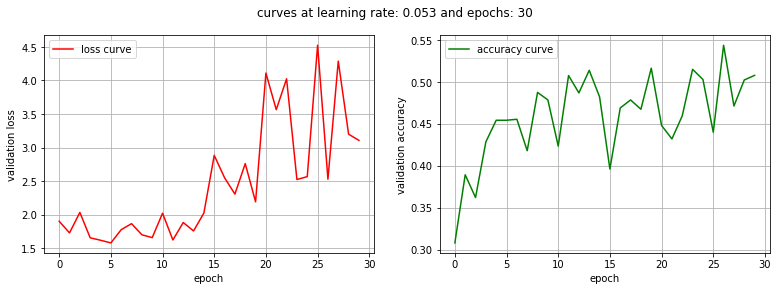

In [ ]:
model = move_to_device(CIFAR10model(), device)
lr=0.053
epoch = 30
optimizer = torch.optim.ASGD(model.parameters(), lr=lr, alpha=0.6749)
model_fit = train_val(model,
                        loss_function,
                        optimizer,
                        Helpers().accuracy,
                        validation_data_loader,
                        training_data_loader,
                        epoch=epoch)
epochs, validation_loss, validation_accuracy = model_fit.fit(grad_flow=False)
test_loss, test_accuracy = model_fit.validation(testing_data_loader)

print(f"Epoch:{epoch}, Learning rate:{lr}, Validation loss:{np.round(validation_loss[-1], 2)}, and Validation accuracy:{np.round(validation_accuracy[-1]*100,2)}")
print(f"Epoch:{epoch}, Learning rate:{lr}, Testing loss:{np.round(test_loss,2)}, and Testing accuracy:{np.round(test_accuracy*100,2)}")
cm = Helpers().confusion_matrix(model, testing_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()
Helpers().plot_curves(epochs, validation_loss, validation_accuracy, lr, epoch)